# Google colab commands

In [1]:
!git clone https://github.com/Francesco9932/financial-sentiment-analysis

fatal: il percorso di destinazione 'financial-sentiment-analysis' esiste già e non è una directory vuota.


In [2]:
%cd financial-sentiment-analysis/

/home/francesco/Documenti/financial-sentiment-analysis/financial-sentiment-analysis


# Data preprocessing and test-train split

In [3]:
import pandas as pd
import numpy as np
from tensorflow.keras.preprocessing.sequence import pad_sequences
from sklearn.model_selection import train_test_split

from tensorflow.keras.preprocessing.text import Tokenizer
import tensorflow as tf

In [4]:
df = pd.read_csv('all-data.csv', encoding="latin-1",
                 names=['sentiment', 'news headline'])
df.head()

,sentiment,news headline
0,neutral,"According to Gran , the company has no plans t..."
1,neutral,Technopolis plans to develop in stages an area...
2,negative,The international electronic industry company ...
3,positive,With the new production plant the company woul...
4,positive,According to the company 's updated strategy f...


<AxesSubplot:>

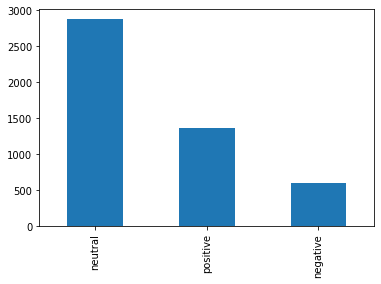

In [5]:
df['sentiment'].value_counts().plot(kind='bar')

In [6]:
print("original shape: ", df.shape)
df = df.drop_duplicates()
print("after drop duplicates shape: ", df.shape)
dd_dn = df.dropna()
print("after drop null shape: ", df.shape)

original shape:  (4846, 2)
after drop duplicates shape:  (4840, 2)
after drop null shape:  (4840, 2)


In [7]:
df['news headline'][1]

'Technopolis plans to develop in stages an area of no less than 100,000 square meters in order to host companies working in computer technologies and telecommunications , the statement said .'

In [8]:
import re
import nltk  #natural language processing
nltk.download("stopwords")
from nltk.corpus import stopwords
from nltk.stem.porter import *

[nltk_data] Downloading package stopwords to
[nltk_data]     /home/francesco/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [9]:
def headline_to_words(headline):
    ''' Convert headline text into a sequence of words '''
    
    # convert to lowercase
    text = headline.lower()
    # remove non letters
    text = re.sub(r"[^a-zA-Z0-9]", " ", text)
    # tokenize
    words = text.split()
    # remove stopwords
    words = [w for w in words if w not in stopwords.words("english")]
    # apply stemming
    words = [PorterStemmer().stem(w) for w in words]
    # return list
    return words

print("\nOriginal headline ->", df['news headline'][0])
print("\nProcessed headline ->", headline_to_words(df['news headline'][0]))


Original headline -> According to Gran , the company has no plans to move all production to Russia , although that is where the company is growing .

Processed headline -> ['accord', 'gran', 'compani', 'plan', 'move', 'product', 'russia', 'although', 'compani', 'grow']


In [10]:
X = list(map(headline_to_words, df['news headline']))

In [11]:
X

[['accord',
  'gran',
  'compani',
  'plan',
  'move',
  'product',
  'russia',
  'although',
  'compani',
  'grow'],
 ['technopoli',
  'plan',
  'develop',
  'stage',
  'area',
  'less',
  '100',
  '000',
  'squar',
  'meter',
  'order',
  'host',
  'compani',
  'work',
  'comput',
  'technolog',
  'telecommun',
  'statement',
  'said'],
 ['intern',
  'electron',
  'industri',
  'compani',
  'elcoteq',
  'laid',
  'ten',
  'employe',
  'tallinn',
  'facil',
  'contrari',
  'earlier',
  'layoff',
  'compani',
  'contract',
  'rank',
  'offic',
  'worker',
  'daili',
  'postime',
  'report'],
 ['new',
  'product',
  'plant',
  'compani',
  'would',
  'increas',
  'capac',
  'meet',
  'expect',
  'increas',
  'demand',
  'would',
  'improv',
  'use',
  'raw',
  'materi',
  'therefor',
  'increas',
  'product',
  'profit'],
 ['accord',
  'compani',
  'updat',
  'strategi',
  'year',
  '2009',
  '2012',
  'baswar',
  'target',
  'long',
  'term',
  'net',
  'sale',
  'growth',
  'rang',
  

In [12]:
from sklearn.preprocessing import LabelEncoder

# Encode target labels
le = LabelEncoder()
le.fit(df['sentiment'])
print(le.classes_)
Y = le.transform(df['sentiment'])

['negative' 'neutral' 'positive']


In [13]:
print(X[0])
print(Y[0])

['accord', 'gran', 'compani', 'plan', 'move', 'product', 'russia', 'although', 'compani', 'grow']
1


In [14]:
tokenizer = Tokenizer(lower=True)
tokenizer.fit_on_texts(X)
sequences = tokenizer.texts_to_sequences(X)
print("Vocab length:", len(tokenizer.word_index) + 1)

max_seq_length = np.max(list(map(lambda x: len(x), sequences)))
print("Maximum sequence length:", max_seq_length)
sequences = pad_sequences(sequences, maxlen=max_seq_length, padding='post')

Vocab length: 7714
Maximum sequence length: 69


In [15]:
train_sequences, test_sequences, y_train, y_test = train_test_split(sequences, Y, train_size=0.7, shuffle=True, random_state=1)

In [16]:
print('Train Set ->', train_sequences.shape, y_train.shape)
print('Test Set ->', test_sequences.shape, y_test.shape)

Train Set -> (3388, 69) (3388,)
Test Set -> (1452, 69) (1452,)


# CNN1d Model

In [19]:
vocab_size = 7714
embedding_size = 128
epochs = 10


inputs = tf.keras.Input(shape=(train_sequences.shape[1],))
x = tf.keras.layers.Embedding(input_dim=vocab_size,
                              output_dim=embedding_size,
                              input_length=train_sequences.shape[1])(inputs)

convs = []
filter_sizes = [2,3,4,5,6]

for filter_size in filter_sizes:
    l_conv = tf.keras.layers.Conv1D(filters=200, 
                        kernel_size=filter_size, 
                        activation='relu')(x)
    l_pool = tf.keras.layers.GlobalMaxPooling1D()(l_conv)
    convs.append(l_pool)

l_merge = tf.keras.layers.concatenate(convs, axis=1)
x = tf.keras.layers.Dropout(0.1)(l_merge)  
x = tf.keras.layers.Dense(128, activation='relu')(x)
x = tf.keras.layers.Dropout(0.2)(x)
outputs = tf.keras.layers.Dense(3, activation='softmax')(x)


model = tf.keras.Model(inputs=inputs, outputs=outputs)

model.compile(optimizer='adam',
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])


history = model.fit(train_sequences,
                    y_train,
                    batch_size=32,
                    epochs=epochs)

Epoch 1/10
106/106 [==============================] - 4s 33ms/step - loss: 0.8728 - accuracy: 0.6113
Epoch 2/10
106/106 [==============================] - 3s 33ms/step - loss: 0.4916 - accuracy: 0.8037
Epoch 3/10
106/106 [==============================] - 4s 34ms/step - loss: 0.1722 - accuracy: 0.9481
Epoch 4/10
106/106 [==============================] - 4s 35ms/step - loss: 0.0714 - accuracy: 0.9805
Epoch 5/10
106/106 [==============================] - 4s 35ms/step - loss: 0.0306 - accuracy: 0.9932
Epoch 6/10
106/106 [==============================] - 4s 35ms/step - loss: 0.0229 - accuracy: 0.9962
Epoch 7/10
106/106 [==============================] - 4s 34ms/step - loss: 0.0142 - accuracy: 0.9973
Epoch 8/10
106/106 [==============================] - 3s 33ms/step - loss: 0.0100 - accuracy: 0.9988
Epoch 9/10
106/106 [==============================] - 4s 33ms/step - loss: 0.0066 - accuracy: 0.9988
Epoch 10/10
106/106 [==============================] - 3s 32ms/step - loss: 0.0077 - accura

In [21]:
results = model.evaluate(test_sequences, y_test, verbose =  0)

print("Test Losss: {:.5f}".format(results[0]))
print("Test accuracy: {:.5f}%".format(results[1]  * 100))

Test Losss: 1.49027
Test accuracy: 72.72727%


# LSTM Model

In [22]:
vocab_size = 7714
embedding_size = 128
epochs = 10


inputs = tf.keras.Input(shape=(train_sequences.shape[1],))
x = tf.keras.layers.Embedding(input_dim=vocab_size,
                              output_dim=embedding_size,
                              input_length=train_sequences.shape[1])(inputs)
x = tf.keras.layers.LSTM(256, return_sequences=True, activation='tanh')(x)
x = tf.keras.layers.Flatten()(x)
outputs = tf.keras.layers.Dense(3, activation='softmax')(x)

model = tf.keras.Model(inputs=inputs, outputs=outputs)

model.compile(optimizer='adam',
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])


history = model.fit(train_sequences,
                    y_train,
                    batch_size=32,
                    epochs=epochs)


Epoch 1/10
106/106 [==============================] - 9s 72ms/step - loss: 0.8240 - accuracy: 0.6346
Epoch 2/10
106/106 [==============================] - 7s 70ms/step - loss: 0.4653 - accuracy: 0.8155
Epoch 3/10
106/106 [==============================] - 8s 71ms/step - loss: 0.2181 - accuracy: 0.9215
Epoch 4/10
106/106 [==============================] - 8s 72ms/step - loss: 0.1152 - accuracy: 0.9575
Epoch 5/10
106/106 [==============================] - 8s 72ms/step - loss: 0.0720 - accuracy: 0.9787
Epoch 6/10
106/106 [==============================] - 8s 72ms/step - loss: 0.0400 - accuracy: 0.9882
Epoch 7/10
106/106 [==============================] - 8s 73ms/step - loss: 0.0281 - accuracy: 0.9929
Epoch 8/10
106/106 [==============================] - 8s 74ms/step - loss: 0.0244 - accuracy: 0.9935
Epoch 9/10
106/106 [==============================] - 8s 74ms/step - loss: 0.0188 - accuracy: 0.9944
Epoch 10/10
106/106 [==============================] - 8s 75ms/step - loss: 0.0119 - accura

In [23]:
results = model.evaluate(test_sequences, y_test, verbose =  0)

print("Test Losss: {:.5f}".format(results[0]))
print("Test accuracy: {:.5f}%".format(results[1]  * 100))

Test Losss: 2.03404
Test accuracy: 70.86777%
